# Binary classification on NSL-KDD dataset

This notebook showcases my work with 3 machine learning algorithms on the NSL kdd Dataset.
The dataset can be found here: https://www.unb.ca/cic/datasets/nsl.html

The dataset has a separated train and test dataset, which makes the algorithm perform much worses on the test dataset than on the train. Going from a ~99% accuracy to a 60-90% on the test set can be seen as badly, but I still consider my results as publishworthy. A reason for this is because the test set contains many new attack types, not seen in the train dataset.

There has been many published papers on the NSL-KDD dataset. There is a split between papers using a part of the train set as the test set, and using the test set as the test set. One could argue that using an unseen part of the train set as the test set would be considered fair for testing the performance of the model, but I would argue that this only creates a fake feeling of trust to the model. In the cyber security space everything is a threat. Constantly there is new malicious attacks, hence the need for a model that could predict new types of attacks based off old attacks. 

This file contains three types of machine learning algorithms. Support vector machines, Decision trees and Random Forests. Although the DT and RF models are wuite similar, they are still super strong algorithms and have their strength and weaknesses. For further works on this data set I would consider building a deep learning model, prefferebly a convolutional neural network, and cosider each line in the dataset as a one dimensional image, as this as been shown promising results on similar datasets. 

# Imports

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn import svm
from sklearn.svm import SVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

## EDA and preprocessing

In [25]:
# feature columns
columns = ['duration','protocol_type','service','flag','src_bytes',
            'dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised',
            'root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds',
            'is_host_login','is_guest_login','count','srv_count',
            'serror_rate','srv_serror_rate','rerror_rate',
            'srv_rerror_rate','same_srv_rate','diff_srv_rate',
            'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
            'dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
            'dst_host_serror_rate','dst_host_srv_serror_rate',
            'dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level']
#after downloading, change the path to your directory
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KDDTrain+.txt', names=columns) 
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KDDTest+.txt', names=columns)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [26]:
def transform_attack(df):
    df['attack'] = np.where(df['attack'] != 'normal', 1, 0)

transform_attack(df_train)
transform_attack(df_test)

df_train['attack'].value_counts(), df_test['attack'].value_counts(), df_train.shape, df_test.shape

(0    67343
 1    58630
 Name: attack, dtype: int64,
 1    12833
 0     9711
 Name: attack, dtype: int64,
 (125973, 43),
 (22544, 43))

In [27]:
def drop_level(df):    
    df.drop(['level'], axis=1, inplace=True)

drop_level(df_train)
drop_level(df_test)
df_train.shape, df_test.shape

((125973, 42), (22544, 42))

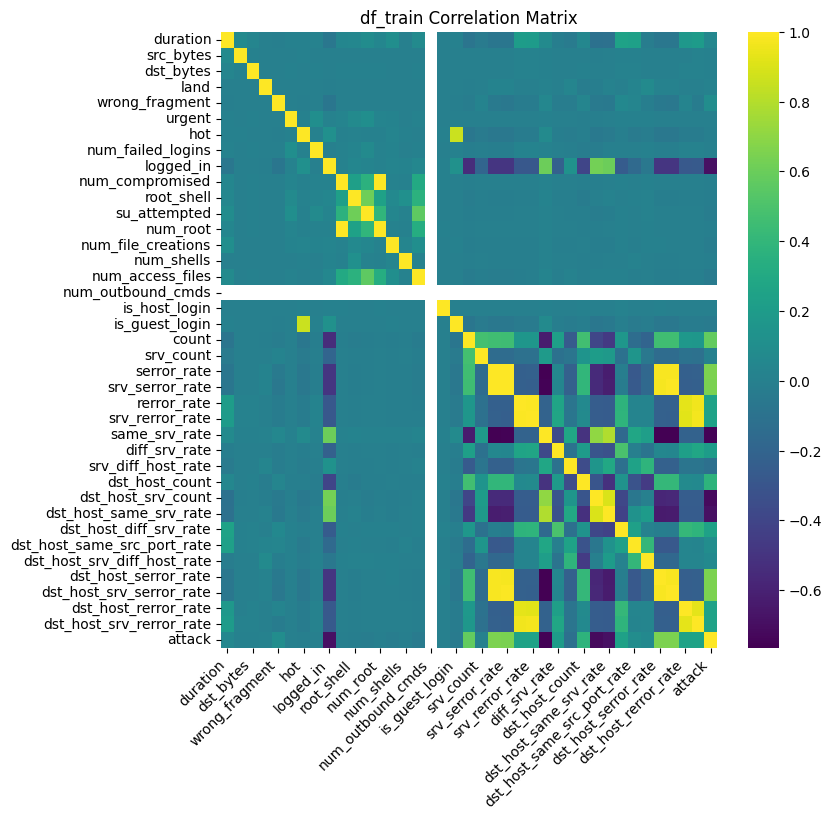

In [28]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_train.corr(), annot=False, cmap='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("df_train Correlation Matrix")
plt.show()

In [29]:
y = df_train[['attack']]
X = df_train.drop(['attack'], axis=1)

X.shape, y.shape

((125973, 41), (125973, 1))

In [30]:
#split df_train into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

#categorical features for one hot encoding
categorical_features = ['protocol_type', 'service', 'flag']
#initializing onehotencoder that can handle unkown values
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#extracting numerical values from x_train and define standard scaler
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = StandardScaler()

#creating a preprosessor function to transform each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features), 
         ('cat', categorical_transformer, categorical_features)])

#preprosessing the train data by applying the defined transformations
X_train_preprocessed = preprocessor.fit_transform(X_train)
#preprosessing the test data by applying the defined transformations
X_test_preprocessed = preprocessor.transform(X_test)


In [31]:
#init the feature selector using mutal information with 25 best features
selector = SelectKBest(mutual_info_classif, k=25)

#fitting the selector to the preprocessd training data and target variable
selector.fit(X_train_preprocessed, y_train)

#extracting the selected features from the features selected from mutal inf
selected_features = np.array(preprocessor.get_feature_names_out())[selector.get_support()]
selected_features

array(['num__src_bytes', 'num__dst_bytes', 'num__logged_in', 'num__count',
       'num__srv_count', 'num__serror_rate', 'num__srv_serror_rate',
       'num__rerror_rate', 'num__same_srv_rate', 'num__diff_srv_rate',
       'num__srv_diff_host_rate', 'num__dst_host_count',
       'num__dst_host_srv_count', 'num__dst_host_same_srv_rate',
       'num__dst_host_diff_srv_rate', 'num__dst_host_same_src_port_rate',
       'num__dst_host_srv_diff_host_rate', 'num__dst_host_serror_rate',
       'num__dst_host_srv_serror_rate', 'num__dst_host_srv_rerror_rate',
       'cat__service_domain_u', 'cat__service_http',
       'cat__service_private', 'cat__flag_S0', 'cat__flag_SF'],
      dtype=object)

In [32]:
#print out the selected features with the corresponding values
feature_scores = selector.scores_

for feature_name, score in zip(selected_features, feature_scores):
    print(f"Feature: {feature_name}, Mutual Information Score: {score}")


Feature: num__src_bytes, Mutual Information Score: 0.025309202476897497
Feature: num__dst_bytes, Mutual Information Score: 0.5662223303436953
Feature: num__logged_in, Mutual Information Score: 0.44159403974238876
Feature: num__count, Mutual Information Score: 0.0
Feature: num__srv_count, Mutual Information Score: 0.00889304456179052
Feature: num__serror_rate, Mutual Information Score: 0.0
Feature: num__srv_serror_rate, Mutual Information Score: 0.011826211136025
Feature: num__rerror_rate, Mutual Information Score: 0.0023053008544626774
Feature: num__same_srv_rate, Mutual Information Score: 0.29017753808234104
Feature: num__diff_srv_rate, Mutual Information Score: 0.006906299836858976
Feature: num__srv_diff_host_rate, Mutual Information Score: 0.0
Feature: num__dst_host_count, Mutual Information Score: 0.00031872259255094626
Feature: num__dst_host_srv_count, Mutual Information Score: 0.003367490195723466
Feature: num__dst_host_same_srv_rate, Mutual Information Score: 0.00247543265111893

In [33]:
#transform the preprocessed train/test data to only include selected features
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

In [35]:
#extracting the x_test and y_test from the original test data set
y_test_new = df_test[['attack']]
X_test_new = df_test.drop(['attack'], axis=1)

#copy the same transformation as I did on the df_train
X_test_new_preprocessed = preprocessor.transform(X_test_new)
X_test_new_selected = selector.transform(X_test_new_preprocessed)

# Training the models

# SVM

In [ ]:
#grid search paramters
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['rbf']
} 

#grid search
grid_search = GridSearchCV(
    svm.SVC(), 
    param_grid, 
    cv=5,  
    verbose=3,  
    n_jobs=-1  
)

#do the grid search
grid_search.fit(X_train_selected, y_train)

#get the best scores
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

#best estimator
best_svm = grid_search.best_estimator_

#validate the on df_train test part
y_pred_grid = best_svm.predict(X_test_selected)
print(classification_report(y_test, y_pred_grid))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score:  0.9931830536009156
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13570
           1       1.00      0.99      0.99     11625

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



In [36]:
svm_model_rbf = SVC(kernel='rbf', C=10, gamma=1)

#fit the mode
svm_model_rbf.fit(X_train_selected, y_train)

#predict the model
y_pred_rbf = svm_model_rbf.predict(X_test_selected)
y_pred_rbf_test = svm_model_rbf.predict(X_test_new_selected)

#evaluate the two test sets
print('RBF train test:\n',classification_report(y_test, y_pred_rbf, digits=7))
print('RBF Real Test:\n', classification_report(y_test_new, y_pred_rbf_test, digits=7))

RBF train test:
               precision    recall  f1-score   support

           0  0.9900081 0.9929993 0.9915014     13570
           1  0.9917990 0.9883011 0.9900470     11625

    accuracy                      0.9908315     25195
   macro avg  0.9909036 0.9906502 0.9907742     25195
weighted avg  0.9908344 0.9908315 0.9908303     25195

RBF Real Test:
               precision    recall  f1-score   support

           0  0.6046281 0.9417156 0.7364310      9711
           1  0.9237094 0.5340139 0.6767727     12833

    accuracy                      0.7096345     22544
   macro avg  0.7641687 0.7378647 0.7066018     22544
weighted avg  0.7862627 0.7096345 0.7024709     22544



In [43]:
accuracy_test_svm = accuracy_score(y_test_new, y_pred_rbf_test)
accuracy_train_svm = accuracy_score(y_test, y_pred_rbf)

print("Accuracy for train_test: ", accuracy_train_svm)
print("Accuracy for test: ", accuracy_test_svm)

Accuracy for train_test:  0.9908315141893232
Accuracy for test:  0.7096344925479063


In [121]:
cm_svm = confusion_matrix(y_test_new, y_pred_rbf_test)

 ## DecisionTree's

In [40]:
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
}

random_search_dt = RandomizedSearchCV(
    DecisionTreeClassifier(), 
    param_distributions=param_dist_dt, 
    n_iter=50,  
    cv=5,  
    verbose=3,  
    n_jobs=-1,  
    random_state=12  
)

random_search_dt.fit(X_train_selected, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f84ceba26b0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f84ceba3d30>},
                   random_state=12, verbose=3)

In [41]:
print("Best parameters: ", random_search_dt.best_params_)
print("Best cross-validation score: ", random_search_dt.best_score_)

Best parameters:  {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 4}
Best cross-validation score:  0.9977772993572487


In [44]:
best_tree = random_search_dt.best_estimator_

#trying out on train-test dataset
y_pred_dt = best_tree.predict(X_test_selected)
y_pred_dt_Test = best_tree.predict(X_test_new_selected)


print('Decision tree train-test set\n', classification_report(y_test, y_pred_dt, digits=7))
print('Decision tree test set\n',classification_report(y_test_new, y_pred_dt_Test, digits=7))

Decision tree train-test set
               precision    recall  f1-score   support

           0  0.9980837 0.9979366 0.9980102     13570
           1  0.9975918 0.9977634 0.9976776     11625

    accuracy                      0.9978567     25195
   macro avg  0.9978378 0.9978500 0.9978439     25195
weighted avg  0.9978568 0.9978567 0.9978567     25195

Decision tree test set
               precision    recall  f1-score   support

           0  0.6455012 0.9714756 0.7756310      9711
           1  0.9650650 0.5962752 0.7371159     12833

    accuracy                      0.7578957     22544
   macro avg  0.8052831 0.7838754 0.7563734     22544
weighted avg  0.8274104 0.7578957 0.7537066     22544



In [46]:
accuracy_test_dt = accuracy_score(y_test_new, y_pred_dt_Test)
accuracy_train_dt = accuracy_score(y_test, y_pred_dt)

print("Accuracy for train_test: ", accuracy_train_dt)
print("Accuracy for test: ", accuracy_test_dt)

Accuracy for train_test:  0.9908315141893232
Accuracy for test:  0.7578956706884316


In [122]:
cm_dt = confusion_matrix(y_test_new, y_pred_dt_Test)

## RandomForest

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=10000, random_state=42)

clf_rf.fit(X_train_selected, y_train)

y_pred_rf = clf_rf.predict(X_test_selected)


In [ ]:
print(classification_report(y_test, y_pred_rf, digits=7))

              precision    recall  f1-score   support

           0  0.9977918 0.9989683 0.9983797     13570
           1  0.9987940 0.9974194 0.9981062     11625

    accuracy                      0.9982536     25195
   macro avg  0.9982929 0.9981938 0.9982430     25195
weighted avg  0.9982543 0.9982536 0.9982535     25195



In [ ]:
y_pred_rf_test = clf_rf.predict(X_test_new_selected)
print(classification_report(y_test_new, y_pred_rf_test, digits=7))

              precision    recall  f1-score   support

           0  0.6636058 0.9748739 0.7896734      9711
           1  0.9705243 0.6260422 0.7611198     12833

    accuracy                      0.7763041     22544
   macro avg  0.8170650 0.8004580 0.7753966     22544
weighted avg  0.8383168 0.7763041 0.7734195     22544



In [ ]:
clf_rf2 = RandomForestClassifier(n_estimators=5, random_state=42)

clf_rf2.fit(X_train_selected, y_train)

y_pred_rf2 = clf_rf.predict(X_test_selected)
print(classification_report(y_test, y_pred_rf2, digits=7))

              precision    recall  f1-score   support

           0  0.9977918 0.9989683 0.9983797     13570
           1  0.9987940 0.9974194 0.9981062     11625

    accuracy                      0.9982536     25195
   macro avg  0.9982929 0.9981938 0.9982430     25195
weighted avg  0.9982543 0.9982536 0.9982535     25195



In [ ]:
y_pred_rf_test = clf_rf2.predict(X_test_new_selected)
print(classification_report(y_test_new, y_pred_rf_test, digits=7))

              precision    recall  f1-score   support

           0  0.6737922 0.9737411 0.7964624      9711
           1  0.9700353 0.6432635 0.7735557     12833

    accuracy                      0.7856192     22544
   macro avg  0.8219137 0.8085023 0.7850091     22544
weighted avg  0.8424263 0.7856192 0.7834230     22544



In [52]:

param_grid_rf = {
    #'n_estimators': [10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'max_depth': [None, 10, 30],
}
grid_search_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid=param_grid_rf,
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search_rf.fit(X_train_selected, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 30], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [53]:
print("Best parameters: ", grid_search_rf.best_params_)
print("Best cross-validation score: ", grid_search_rf.best_score_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score:  0.9983032086761219


In [54]:
best_forest = grid_search_rf.best_estimator_


y_pred_rf = best_forest.predict(X_test_selected)
print('RF train-test\n', classification_report(y_test, y_pred_rf, digits=7))

y_pred_rf_test = best_forest.predict(X_test_new_selected)
print('RF test\n', classification_report(y_test_new, y_pred_rf_test, digits=7))

RF train-test
               precision    recall  f1-score   support

           0  0.9977184 0.9989683 0.9983430     13570
           1  0.9987939 0.9973333 0.9980631     11625

    accuracy                      0.9982139     25195
   macro avg  0.9982562 0.9981508 0.9982030     25195
weighted avg  0.9982147 0.9982139 0.9982138     25195

RF test
               precision    recall  f1-score   support

           0  0.6678894 0.9749768 0.7927324      9711
           1  0.9709608 0.6331333 0.7664733     12833

    accuracy                      0.7803850     22544
   macro avg  0.8194251 0.8040551 0.7796029     22544
weighted avg  0.8404105 0.7803850 0.7777846     22544



In [93]:
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['entropy'],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'max_depth': [30],
}
grid_search_rf_refined = GridSearchCV(
    RandomForestClassifier(),
    param_grid=param_grid_rf,
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search_rf_refined.fit(X_train_selected, y_train)



Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [30],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [10, 50, 100, 200]},
             verbose=3)

In [94]:
print("Best parameters: ", grid_search_rf_refined.best_params_)
print("Best cross-validation score: ", grid_search_rf_refined.best_score_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score:  0.9982635177690422


In [95]:
best_forest = grid_search_rf_refined.best_estimator_


y_pred_rf_r = best_forest.predict(X_test_selected)
print('RF train-test\n', classification_report(y_test, y_pred_rf_r, digits=7))

y_pred_rf_test_r = best_forest.predict(X_test_new_selected)
print('RF test\n', classification_report(y_test_new, y_pred_rf_test_r, digits=7))

RF train-test
               precision    recall  f1-score   support

           0  0.9977182 0.9988946 0.9983061     13570
           1  0.9987079 0.9973333 0.9980201     11625

    accuracy                      0.9981742     25195
   macro avg  0.9982131 0.9981140 0.9981631     25195
weighted avg  0.9981749 0.9981742 0.9981742     25195

RF test
               precision    recall  f1-score   support

           0  0.6620043 0.9747709 0.7885048      9711
           1  0.9702850 0.6233928 0.7590853     12833

    accuracy                      0.7747516     22544
   macro avg  0.8161447 0.7990818 0.7737950     22544
weighted avg  0.8374908 0.7747516 0.7717580     22544



In [120]:
parameters = {
    'criterion': 'entropy',
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 5
}

rf_model = RandomForestClassifier(**parameters)
rf_model.fit(X_train_selected, y_train)


y_pred_rf_n50 = rf_model.predict(X_test_new_selected)
print('RF test n=50\n', classification_report(y_test_new, y_pred_rf_n50, digits=7))


RF test n=50
               precision    recall  f1-score   support

           0  0.6774078 0.9741530 0.7991215      9711
           1  0.9707425 0.6489519 0.7778816     12833

    accuracy                      0.7890348     22544
   macro avg  0.8240752 0.8115525 0.7885015     22544
weighted avg  0.8443863 0.7890348 0.7870308     22544



Suprisingly this gave me a worse performance on KDDTest+

In [55]:
accuracy_test_rf = accuracy_score(y_test_new, y_pred_rf_test)
accuracy_train_rf = accuracy_score(y_test, y_pred_rf)

print("Accuracy for train_test: ", accuracy_train_dt)
print("Accuracy for test: ", accuracy_test_dt)

Accuracy for train_test:  0.9908315141893232
Accuracy for test:  0.7578956706884316


In [125]:
cm_rf = confusion_matrix(y_test_new, y_pred_rf_n50)

# Now lets plot the results

In [56]:
#now lets get all of the other features

#svm
precision_test_svm = precision_score(y_test_new, y_pred_rbf_test)
precision_train_svm = precision_score(y_test, y_pred_rbf)
recall_test_svm = recall_score(y_test_new, y_pred_rbf_test)
recall_train_svm = recall_score(y_test, y_pred_rbf)

#dt
precision_test_dt = precision_score(y_test_new, y_pred_dt_Test)
precision_train_dt = precision_score(y_test, y_pred_dt)
recall_test_dt = recall_score(y_test_new, y_pred_dt_Test)
recall_train_dt = recall_score(y_test, y_pred_dt)

#rf
precision_test_rf = precision_score(y_test_new, y_pred_rf_test)
precision_train_rf = precision_score(y_test, y_pred_rf)
recall_test_rf = recall_score(y_test_new, y_pred_rf_test)
recall_train_rf = recall_score(y_test, y_pred_rf)

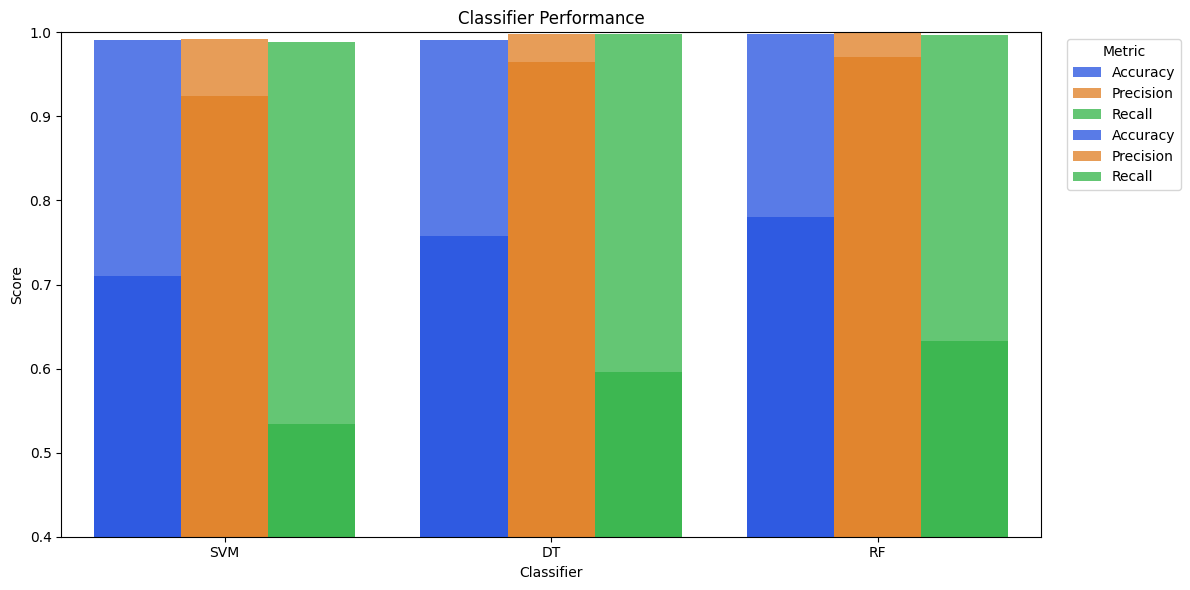

In [91]:
df = pd.DataFrame({
    'Classifier': ['SVM', 'SVM', 'SVM', 'DT', 'DT', 'DT', 'RF', 'RF', 'RF'],
    'Metric': ['Accuracy', 'Precision', 'Recall']*3,
    'Train': [accuracy_train_svm, precision_train_svm, recall_train_svm, 
              accuracy_train_dt, precision_train_dt, recall_train_dt, 
              accuracy_train_rf, precision_train_rf, recall_train_rf],
    'Test': [accuracy_test_svm, precision_test_svm, recall_test_svm, 
             accuracy_test_dt, precision_test_dt, recall_test_dt, 
             accuracy_test_rf, precision_test_rf, recall_test_rf]
})

# reshape the data for plotting
df_melted = df.melt(id_vars=["Classifier", "Metric"], 
                    value_vars=["Train", "Test"],
                    var_name="Data", 
                    value_name="Value")

# use seaborn color palette
colors = sns.color_palette('bright')

fig, ax = plt.subplots(figsize=(12,6))

for i, data in enumerate(['Train', 'Test']):
    df_filtered = df_melted[df_melted['Data'] == data]
    sns.barplot(x='Classifier', y='Value', hue='Metric', data=df_filtered, 
                palette=colors, alpha=0.75, ax=ax)


ax.set_xlabel('Classifier')
ax.set_ylabel('Score')
ax.set_ylim(0.4, 1)
ax.set_title('Classifier Performance')
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

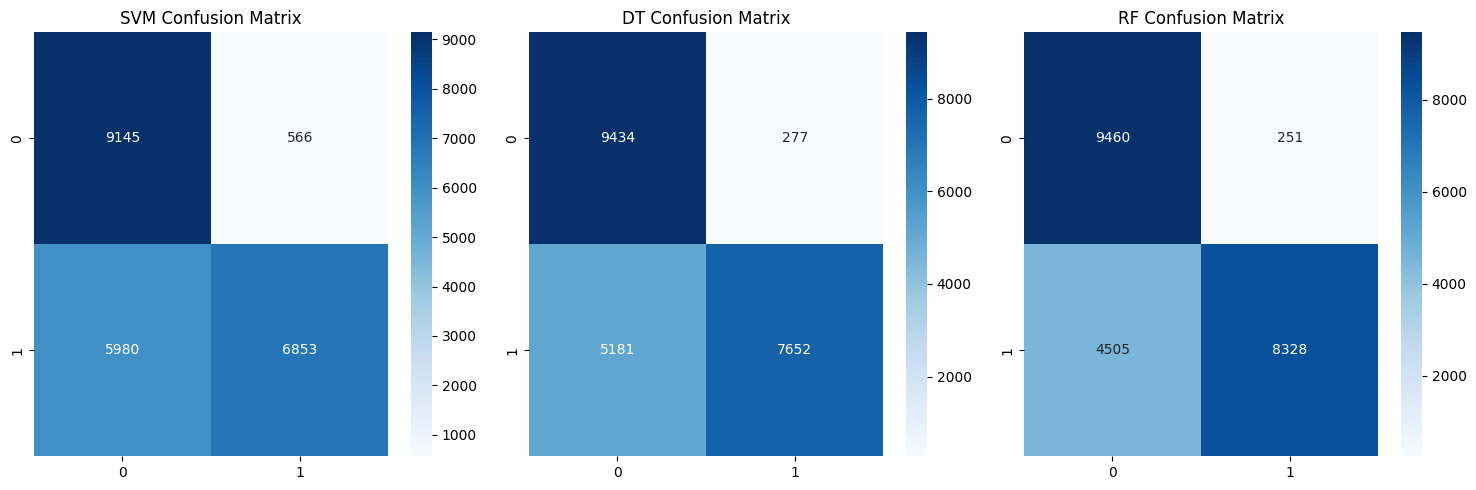

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#SVM cm
sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='d', ax=axes[0])
axes[0].set_title('SVM Confusion Matrix')

#DT cm
sns.heatmap(cm_dt, annot=True, cmap='Blues', fmt='d', ax=axes[1])
axes[1].set_title('DT Confusion Matrix')

#RF cm
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d', ax=axes[2])
axes[2].set_title('RF Confusion Matrix')

plt.tight_layout()
plt.show()

## Important papers
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8759867
- SVM on NSL-KDD https://arxiv.org/pdf/2209.05579.pdf
- https://ieeexplore.ieee.org/document/9418291